In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision.transforms import transforms

torch.set_printoptions(linewidth=120)

In [2]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        t = t

        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)
        t = self.out(t)

        return t


In [4]:
train_set = torchvision.datasets.FashionMNIST(root='/.data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)


for epoch in range(5):

    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

        print(f'epoch {epoch}, total loss: {total_loss}, total correct: {total_correct}')


epoch 0, total loss: 2.303834915161133, total correct: 11
epoch 0, total loss: 4.612119436264038, total correct: 19
epoch 0, total loss: 6.904358625411987, total correct: 27
epoch 0, total loss: 9.14095139503479, total correct: 41
epoch 0, total loss: 11.320627689361572, total correct: 51
epoch 0, total loss: 13.352704286575317, total correct: 78
epoch 0, total loss: 15.32993495464325, total correct: 103
epoch 0, total loss: 16.97467052936554, total correct: 140
epoch 0, total loss: 18.478108286857605, total correct: 183
epoch 0, total loss: 19.99209713935852, total correct: 222
epoch 0, total loss: 21.305771112442017, total correct: 272
epoch 0, total loss: 22.649999737739563, total correct: 319
epoch 0, total loss: 23.866562128067017, total correct: 370
epoch 0, total loss: 25.213268995285034, total correct: 415
epoch 0, total loss: 26.487539052963257, total correct: 469
epoch 0, total loss: 27.4739933013916, total correct: 530
epoch 0, total loss: 28.598456978797913, total correct: 

In [6]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds), dim=0
        )
    return all_preds


In [7]:
len(train_set)

60000

In [8]:
len(train_set.targets)

60000

In [9]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [10]:
train_preds.shape

torch.Size([60000, 10])

In [11]:
print(train_preds.requires_grad)

False


In [12]:
preds_correct = get_num_correct(train_preds, train_set.targets)       
print(f'total correct: {preds_correct}')
print(f'accuracy: {preds_correct/len(train_set)}')


total correct: 52234
accuracy: 0.8705666666666667


In [13]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [14]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [16]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix


In [17]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))     #confmatrix(ytest, ypred)
print(type(cm))
cm


<class 'numpy.ndarray'>


array([[5563,   11,   60,  154,   13,    1,  144,    2,   52,    0],
       [  21, 5897,    3,   56,   10,    0,    4,    1,    8,    0],
       [ 132,    7, 4329,   72, 1117,    2,  273,    2,   65,    1],
       [ 179,  130,    7, 5470,  101,    0,   74,    2,   37,    0],
       [  13,   12,  213,  376, 5075,    0,  271,    0,   40,    0],
       [   3,    0,    0,    0,    0, 5634,    0,  250,   33,   80],
       [1586,   13,  565,  154,  656,    2, 2923,    1,  100,    0],
       [   0,    0,    0,    0,    0,   19,    0, 5902,    3,   76],
       [  33,    0,    7,   12,   22,    6,   19,   16, 5885,    0],
       [   0,    0,    0,    1,    0,   19,    1,  421,    2, 5556]],
      dtype=int64)

Confusion matrix, without normalization
[[5563   11   60  154   13    1  144    2   52    0]
 [  21 5897    3   56   10    0    4    1    8    0]
 [ 132    7 4329   72 1117    2  273    2   65    1]
 [ 179  130    7 5470  101    0   74    2   37    0]
 [  13   12  213  376 5075    0  271    0   40    0]
 [   3    0    0    0    0 5634    0  250   33   80]
 [1586   13  565  154  656    2 2923    1  100    0]
 [   0    0    0    0    0   19    0 5902    3   76]
 [  33    0    7   12   22    6   19   16 5885    0]
 [   0    0    0    1    0   19    1  421    2 5556]]


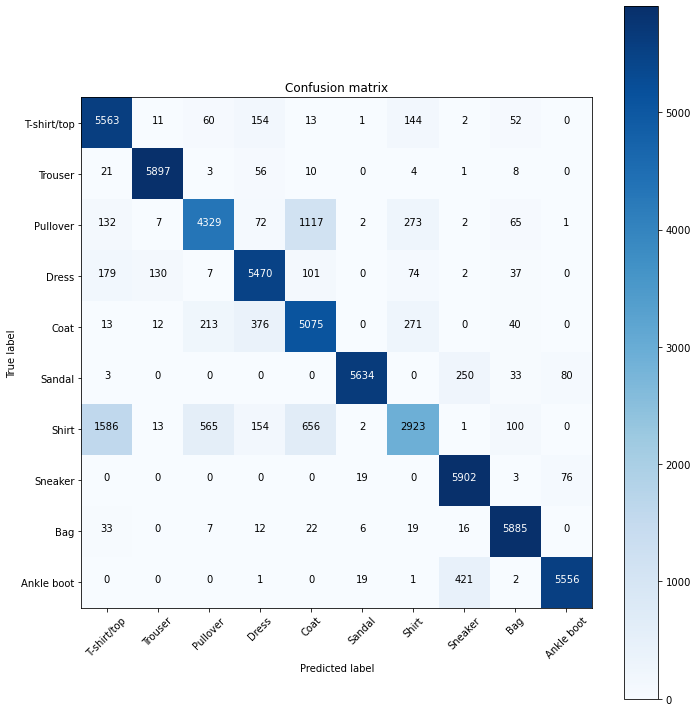

In [18]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, train_set.classes)
